@author: Amaury Lancelin  

This notebook contains the code to reproduce the interpretability plots for CNN Expected Gradients Feature Importance.

In [1]:
import os 
import sys
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import seaborn as sns
import importlib as imp
import pandas as pd
import scipy.ndimage
import seaborn as sns
sns.set_theme()

# CNN Feature Importance with Shap Expected Gradients

In [2]:
path_to_data_plots = os.getcwd() 

# load EGFI CNN
shap_values = np.load(path_to_data_plots + "/CNN-EGFI/shap_values.npy")
shap_values_mu = np.load(path_to_data_plots + "/CNN-EGFI/shap_values_mu.npy")
shap_values_sigma = np.load(path_to_data_plots + "/CNN-EGFI/shap_values_sigma.npy")
preds = np.load(path_to_data_plots + "/CNN-EGFI/preds.npy")
preds_mu = np.load(path_to_data_plots + "/CNN-EGFI/preds_mu.npy")
preds_sigma = np.load(path_to_data_plots + "/CNN-EGFI/preds_sigma.npy")
indices = np.load(path_to_data_plots + "/CNN-EGFI/indices.npy") # This is random indices selected among the heatwave cases in the test set
X_test_sub = np.load(path_to_data_plots + "/CNN-EGFI/X_test_sub.npy")
A_test_sub = np.load(path_to_data_plots + "/CNN-EGFI/A_test_sub.npy")

lon = np.load(path_to_data_plots + "/common/lon.npy")
lat = np.load(path_to_data_plots + "/common/lat.npy")



# path to GA
# path in github zenodo: "interpretability-hierarchy/GA/r800y/0/fold_0"

path_GA = os.getcwd() + "/GA/r800y/0/fold_0/"
pattern_ga = np.load(path_GA+ "proj.npy")*np.load(path_GA+'msigma.npy')[0]
mu_ga = np.load(path_GA + "Y_pred_te.npy")[:,0]
# print(mu_ga[indices], A_test[indices], preds_ga)

# check the sum of the pattern with the prediction
for i, index in enumerate(indices[:4]):
    input_data = X_test_sub[i, :, :, :].copy()
    s = np.sum(input_data * pattern_ga)
    norm_p =  mu_ga[index] / s
    print(s, mu_ga[index])

1.8626373734290778 1.8596748927356899
3.4050475818893156 3.40810516890639
3.7892739831243 3.79122642498884
2.552555528842652 2.5504752010057556


In [3]:
for i, index in enumerate(indices[:4]):
    input_data = X_test_sub[i, :, :, :].copy()
    input_data[:,:,1] = input_data[:,:,1]*0.
    s = np.sum(input_data * pattern_ga)
    s_CNN = np.sum(shap_values_mu[i, ...,0])
    mu_CNN = preds_mu[i]
    print(f"Heatwave: index={index}")
    print(f"percentage of FI Z500 (GA) = {(s/mu_ga[index])*100:.2f}%")
    print(f"percentage of FI Z500 (CNN) = {(s_CNN/mu_CNN)*100:.2f}%")
    print("---"*12)



fi_GA = pattern_ga
# total importance
total_importance = np.sum(np.abs(fi_GA))
print(f'Total importance = {total_importance}')

# relative importance of Z500 and SM
percent_fi_Z500 = np.sum(np.abs(fi_GA[:,:,0]))/total_importance*100
percent_fi_SM = np.sum(np.abs(fi_GA[:,:,1]))/total_importance*100
print(f'Relative importance of Z500 = {percent_fi_Z500:.2f}%', f'\nRelative importance of SM = {percent_fi_SM:.2f}%')

Heatwave: index=13284
percentage of FI Z500 (GA) = 68.46%
percentage of FI Z500 (CNN) = 69.20%
------------------------------------
Heatwave: index=6086
percentage of FI Z500 (GA) = 78.39%
percentage of FI Z500 (CNN) = 73.93%
------------------------------------
Heatwave: index=12726
percentage of FI Z500 (GA) = 92.50%
percentage of FI Z500 (CNN) = 86.76%
------------------------------------
Heatwave: index=595
percentage of FI Z500 (GA) = 72.05%
percentage of FI Z500 (CNN) = 76.25%
------------------------------------
Total importance = 7.133583584100444
Relative importance of Z500 = 94.79% 
Relative importance of SM = 5.21%


#### Fig 2. Article

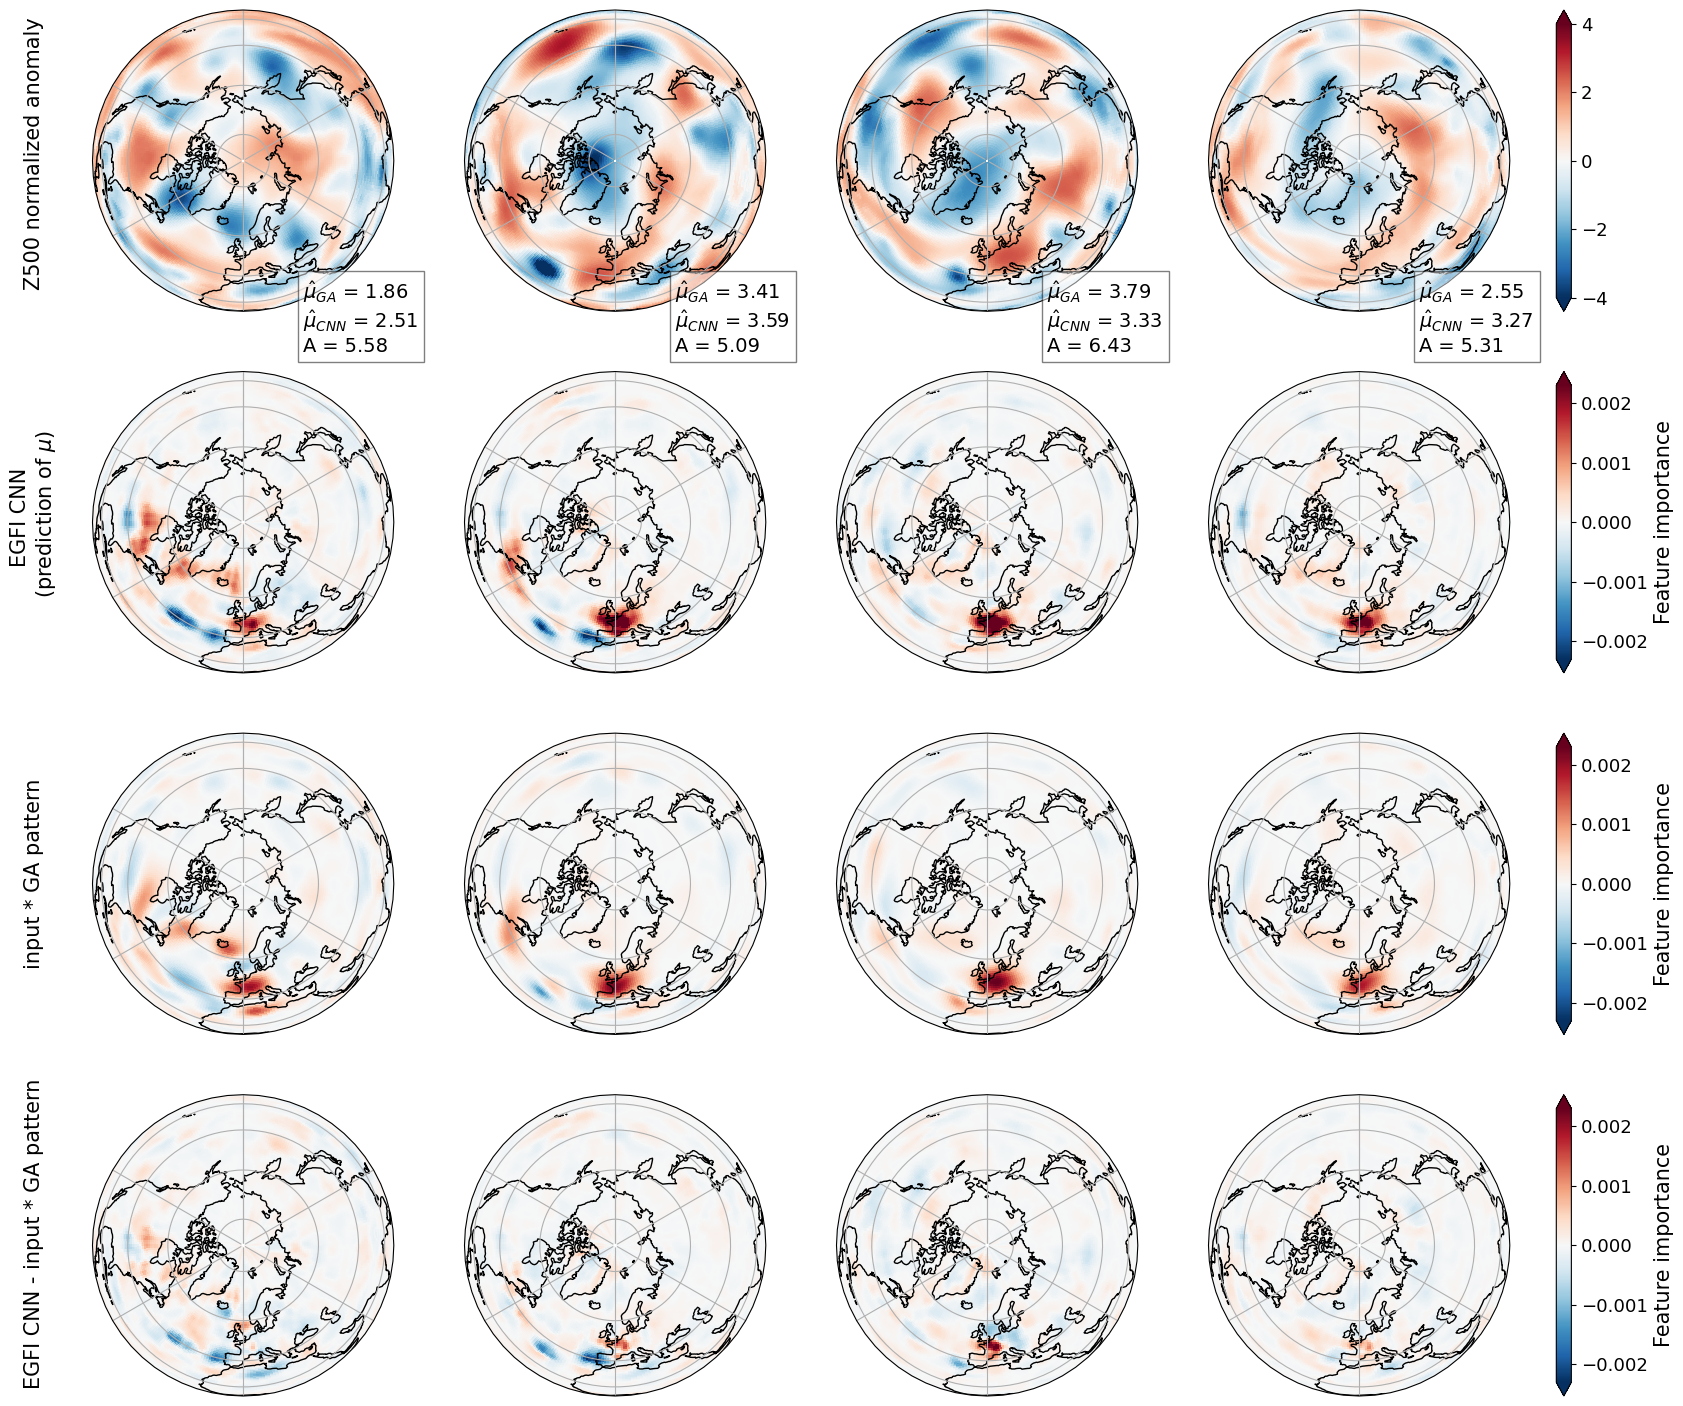

In [4]:
# set matplotlib default params
plt.rcParams.update(plt.rcParamsDefault)
# Do the same as before nut in a one plot with 10 subplots (2 lines of 5 subplots)
# Create a map projection for the Northern Hemisphere
projection = ccrs.Orthographic(central_latitude=90)
# projection = ccrs.NorthPolarStereo()

# Create a Matplotlib figure and axis
n_col= 4
fig, axs = plt.subplots(4, n_col, subplot_kw={'projection': projection}, figsize=(20, 18))
font_tick = 13
font_size_colorbar = 15
pad_colorbar = 0.03
font_size_title = 15

for i, index in enumerate(indices[:n_col]):

    ax = axs[0, i%n_col]
    input_data = X_test_sub[i, :, :, 0].copy()
    # Plot the map data using pcolormesh
    img = ax.pcolormesh(lon, lat, input_data, transform=ccrs.PlateCarree(), cmap='RdBu_r')
    # set the value 0 to white
    img.set_clim(vmin=-4, vmax=4)
    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines()
    # Add colorbar
    ax.text(0.7, -0.15, f"$\hat{{\mu}}_{{GA}}$ = {mu_ga[index]:.2f}\n$\hat{{\mu}}_{{CNN}}$ = {preds_mu[i]:.2f}\nA = {A_test_sub[i]:.2f}", 
        transform=ax.transAxes, fontsize=14, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))
    if i == n_col -1:
        cbar = plt.colorbar(img, ax=axs[0, :], orientation='vertical', fraction=0.05, pad=pad_colorbar, extend='both')
        cbar.ax.tick_params(labelsize=font_tick)

    ########### SHAP with predicted mu
    shap_data = shap_values_mu[i, ...,0].copy()
    shap_data = shap_data/preds_mu[i] # normalize the feature importance map by the total importance
    import scipy.ndimage
    shap_data = scipy.ndimage.gaussian_filter(shap_data, sigma=1.3)

    ax = axs[1, i%n_col]
    # Plot the map data using pcolormesh
    img = ax.pcolormesh(lon, lat, shap_data, transform=ccrs.PlateCarree(), cmap='RdBu_r') #cmap='jet')
    # set the value 0 to white
    scale =0.0023
    v_min = -scale
    v_max = scale
    # img.set_clim(vmin=-scale*np.abs(map_data).max(), vmax=scale*np.abs(map_data).max())
    img.set_clim(vmin=v_min, vmax=v_max)
    img.set_clim(vmin=None, vmax=None)
    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines()
    # cbar.set_label(r"$\hat{\mu}_{GA}$ = " + f"{mu_ga[index]:.2f}" +
    #                 r", $\hat{\mu}_{CNN}$ = " + f"{preds_mu[i]:.2f}" + r", A = " + f"{A_test[index]:.2f}", fontsize=13)

    # Add colorbar
    if i == n_col -1:
        cbar = plt.colorbar(img, ax=axs[1, :], orientation='vertical', fraction=0.05, pad=pad_colorbar, extend='both')
        cbar.ax.tick_params(labelsize=font_tick)
        cbar.set_label('Feature importance', fontsize=font_size_colorbar)

    ########### input * Gaussian approximation pattern
    GA_data = input_data * pattern_ga[:,:,0]
    GA_data = GA_data/mu_ga[index] #normalize the feature importance map by the total importance

    ax = axs[2, i%n_col]
    img = ax.pcolormesh(lon, lat, GA_data, transform=ccrs.PlateCarree(), cmap='RdBu_r') #cmap='jet')
    # set the value 0 to white
    img.set_clim(vmin=v_min, vmax=v_max)
    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines()
    # Add colorbar
    if i == n_col -1:
        cbar = plt.colorbar(img, ax=axs[2, :], orientation='vertical', fraction=0.05, pad=pad_colorbar, extend='both')
        cbar.ax.tick_params(labelsize=font_tick)
        cbar.set_label('Feature importance', fontsize=font_size_colorbar)


    # add the difference between the two maps
    diff = shap_data - GA_data
    ax = axs[3, i%n_col]
    img = ax.pcolormesh(lon, lat, diff, transform=ccrs.PlateCarree(), cmap='RdBu_r') #cmap='jet')
    # set the value 0 to white
    img.set_clim(vmin=v_min, vmax=v_max)
    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines()
    # Add colorbar
    if i == n_col -1:
            cbar = plt.colorbar(img, ax=axs[3, :], orientation='vertical', fraction=0.05, pad=pad_colorbar, extend='both')
            cbar.ax.tick_params(labelsize=font_tick)
            cbar.set_label('Feature importance', fontsize=font_size_colorbar)

# Add vertical titles
titles = ['Z500 normalized anomaly', 'EGFI CNN \n' + r"(prediction of $\mu$)", r'input * GA pattern',
            r'EGFI CNN - input * GA pattern']
# for i, title in enumerate(titles):
#     fig.text(0.06, 0.85 - i * 0.31, title, va='center', ha='center', rotation='vertical', fontsize=20)
    # Add vertical titles
for i, title in enumerate(titles):
    fig.text(0.1, 0.8 - i * 0.2, title, va='center', ha='center', rotation='vertical', fontsize=font_size_title)
    
    
plt.show()

#### Same Figure but for Soil Moisture

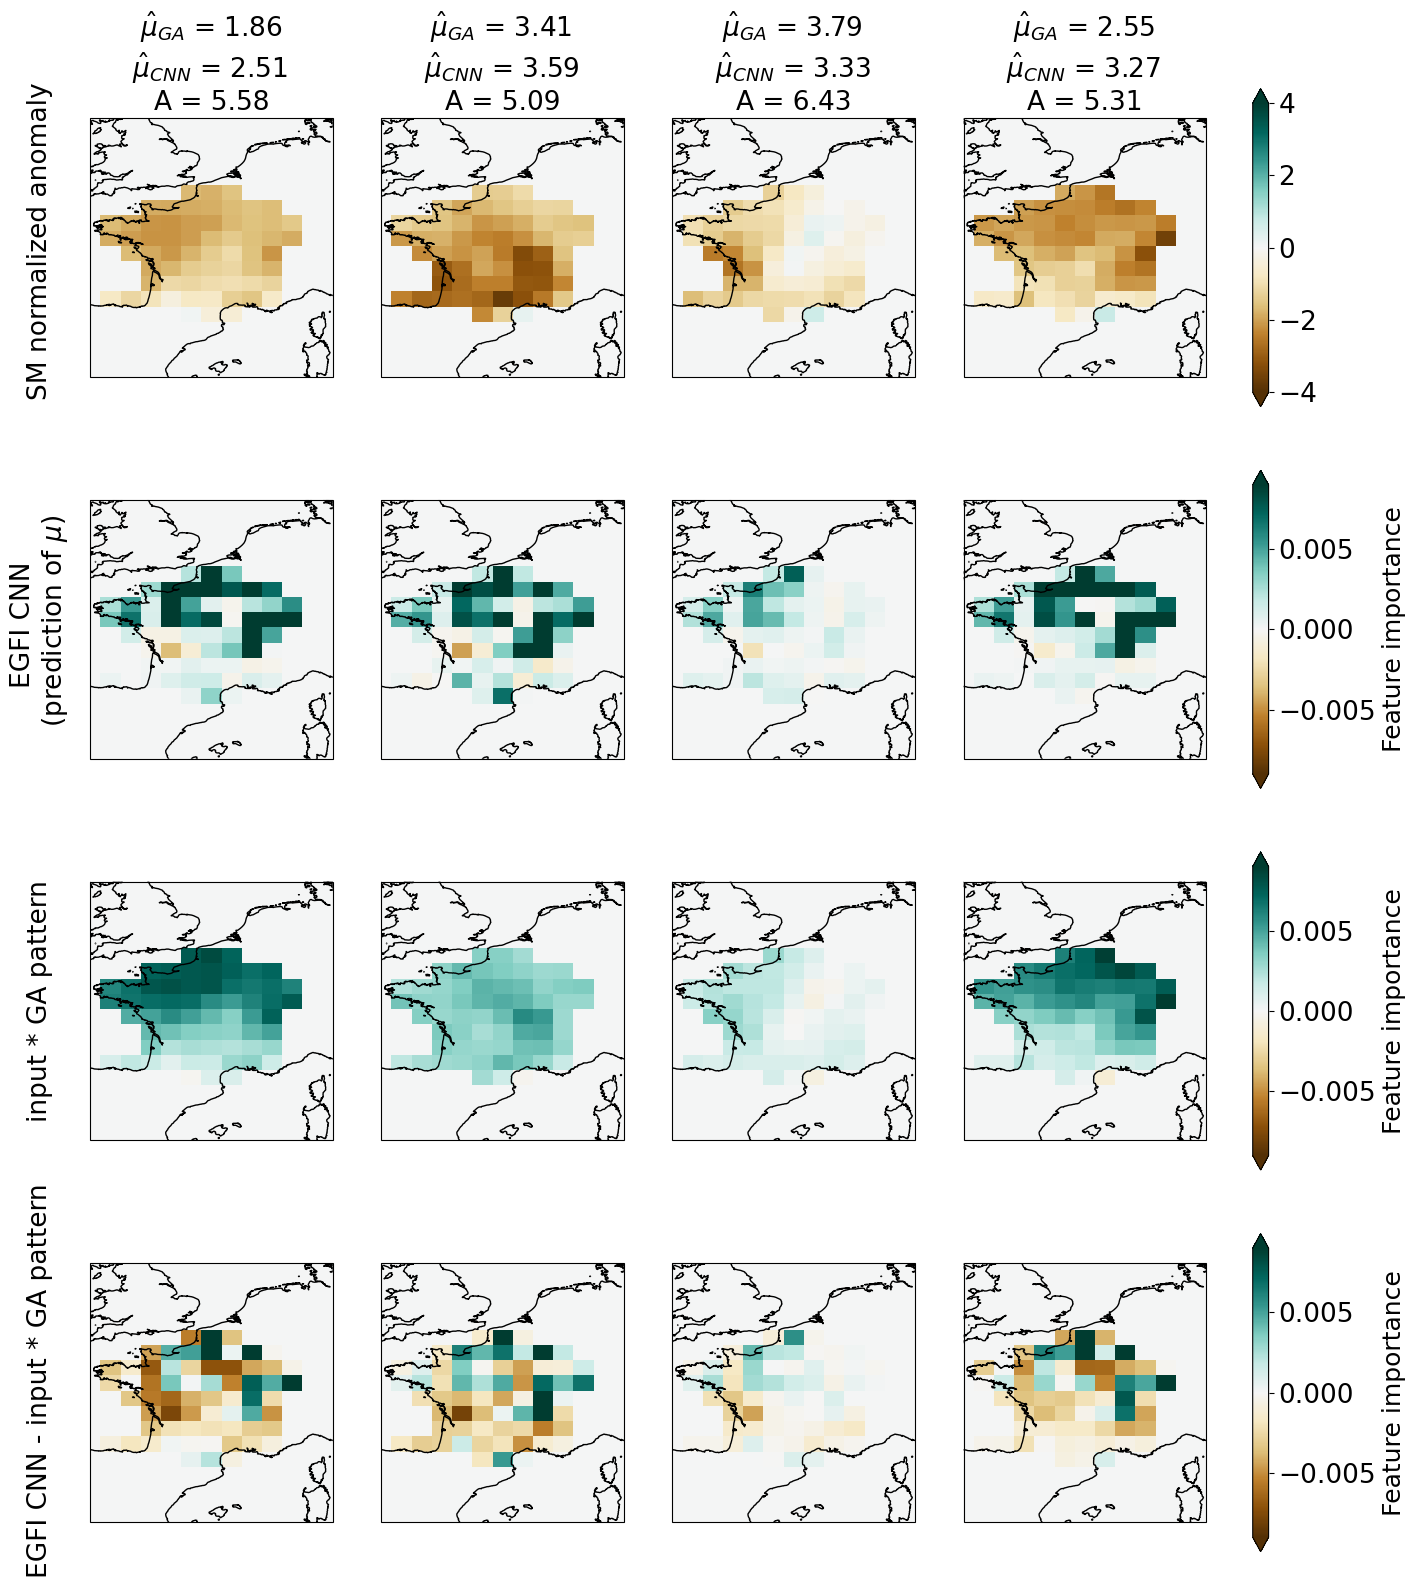

In [5]:
# set matplotlib default params
plt.rcParams.update(plt.rcParamsDefault)

# Create a map projection for the Northern Hemisphere
projection = ccrs.Orthographic(central_latitude=90)
projection = ccrs.PlateCarree()
# projection = ccrs.NorthPolarStereo()

# Create a Matplotlib figure and axis
n_col = 4
fig, axs = plt.subplots(4, n_col, subplot_kw={'projection': projection}, figsize=(20, 19))

# Define font sizes
font_tick = 19
font_size_colorbar = 18
pad_colorbar = 0.03
font_size_title = 19
annotation_fontsize = 14
fraction_colorbar = 0.25


for i, index in enumerate(indices[:n_col]):

    ax = axs[0, i % n_col]
    input_data = X_test_sub[i, :, :, 1].copy()
    # Plot the map data using pcolormesh
    img = ax.pcolormesh(lon, lat, input_data, transform=ccrs.PlateCarree(), cmap='BrBG')
    France_extent = [-13, 17, 35, 60]
    France_extent = [-5, 10, 39, 55]
    ax.set_extent(France_extent, crs=ccrs.PlateCarree())
    # set the value 0 to white
    img.set_clim(vmin=-4, vmax=4)
    # Add coastlines and gridlines
    ax.coastlines()
    # ax.gridlines()
    ax.set_title(r"$\hat{\mu}_{GA}$ = " + f"{mu_ga[index]:.2f} \n" +
                    r"$\hat{\mu}_{CNN}$ = " + f"{preds_mu[i]:.2f} \n" + r"A = " + f"{A_test_sub[i]:.2f}", fontsize=font_size_title)
    # Add colorbar
    if i == n_col -1:
        cbar = plt.colorbar(img, ax=axs[0, :], orientation='vertical', fraction=fraction_colorbar, pad=pad_colorbar, extend='both')
        cbar.ax.tick_params(labelsize=font_tick)

    ########### SHAP with predicted mu
    shap_data = shap_values_mu[i, ..., 1].copy()
    shap_data = shap_data / preds_mu[i]  # normalize the feature importance map by the total importance

    ax = axs[1, i % n_col]
    # Plot the map data using pcolormesh
    img = ax.pcolormesh(lon, lat, shap_data, transform=ccrs.PlateCarree(), cmap='BrBG')
    ax.set_extent(France_extent, crs=ccrs.PlateCarree())  # cmap='jet')
    # set the value 0 to white
    scale = 0.009
    v_min = -scale
    v_max = scale
    img.set_clim(vmin=v_min, vmax=v_max)
    img.set_clim(vmin=None, vmax=None)
    # Add coastlines and gridlines
    ax.coastlines()

    # Add colorbar
    if i == n_col -1:
        cbar = plt.colorbar(img, ax=axs[2, :], orientation='vertical', fraction=fraction_colorbar, pad=pad_colorbar, extend='both')
        cbar.ax.tick_params(labelsize=font_tick)
        # cbar.formatter.set_powerlimits((0, 2))
        # # cbar.update_ticks()
        cbar.set_label('Feature importance', fontsize=font_size_colorbar)

    ########### input * Gaussian approximation pattern
    GA_data = input_data * pattern_ga[:, :, 1]
    GA_data = GA_data / mu_ga[index]  # normalize the feature importance map by the total importance
    ax = axs[2, i % n_col]
    img = ax.pcolormesh(lon, lat, GA_data, transform=ccrs.PlateCarree(), cmap='BrBG')  # cmap='jet')
    ax.set_extent(France_extent, crs=ccrs.PlateCarree())
    # set the value 0 to white
    img.set_clim(vmin=v_min, vmax=v_max)
    # Add coastlines and gridlines
    ax.coastlines()
    # Add colorbar
    if i == n_col -1:
        cbar = plt.colorbar(img, ax=axs[1, :], orientation='vertical', fraction=fraction_colorbar, pad=pad_colorbar, extend='both')
        cbar.ax.tick_params(labelsize=font_tick)
        # cbar.formatter.set_powerlimits(
        # # cbar.update_ticks()
        cbar.set_label('Feature importance', fontsize=font_size_colorbar)

    ############################################
    # add the difference between the two maps
    diff = shap_data - GA_data
    ax = axs[3, i % n_col]
    img = ax.pcolormesh(lon, lat, diff, transform=ccrs.PlateCarree(), cmap='BrBG')  # cmap='jet')
    ax.set_extent(France_extent, crs=ccrs.PlateCarree())
    # set the value 0 to white
    img.set_clim(vmin=v_min, vmax=v_max)
    # Add coastlines and gridlines
    ax.coastlines()
    # # Add colorbar
    if i == n_col -1:
        cbar = plt.colorbar(img, ax=axs[3, :], orientation='vertical', fraction=fraction_colorbar, pad=pad_colorbar, extend='both')
        cbar.ax.tick_params(labelsize=font_tick)
        # cbar.formatter.set_powerlimits((0, 2))
        # # cbar.update_ticks()
        cbar.set_label('Feature importance', fontsize=font_size_colorbar)


# Add vertical titles
titles = ['SM normalized anomaly', 'EGFI CNN \n' + r"(prediction of $\mu$)", r'input * GA pattern',
            r'EGFI CNN - input * GA pattern']
# for i, title in enumerate(titles):
#     fig.text(0.06, 0.85 - i * 0.31, title, va='center', ha='center', rotation='vertical', fontsize=20)
    # Add vertical titles
for i, title in enumerate(titles):
    fig.text(0.1, 0.80 - i * 0.2, title, va='center', ha='center', rotation='vertical', fontsize=19)

# Adjust layout to make room for the vertical text
# plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.05)
for ax in axs.flatten():
    ax.gridlines
plt.show()

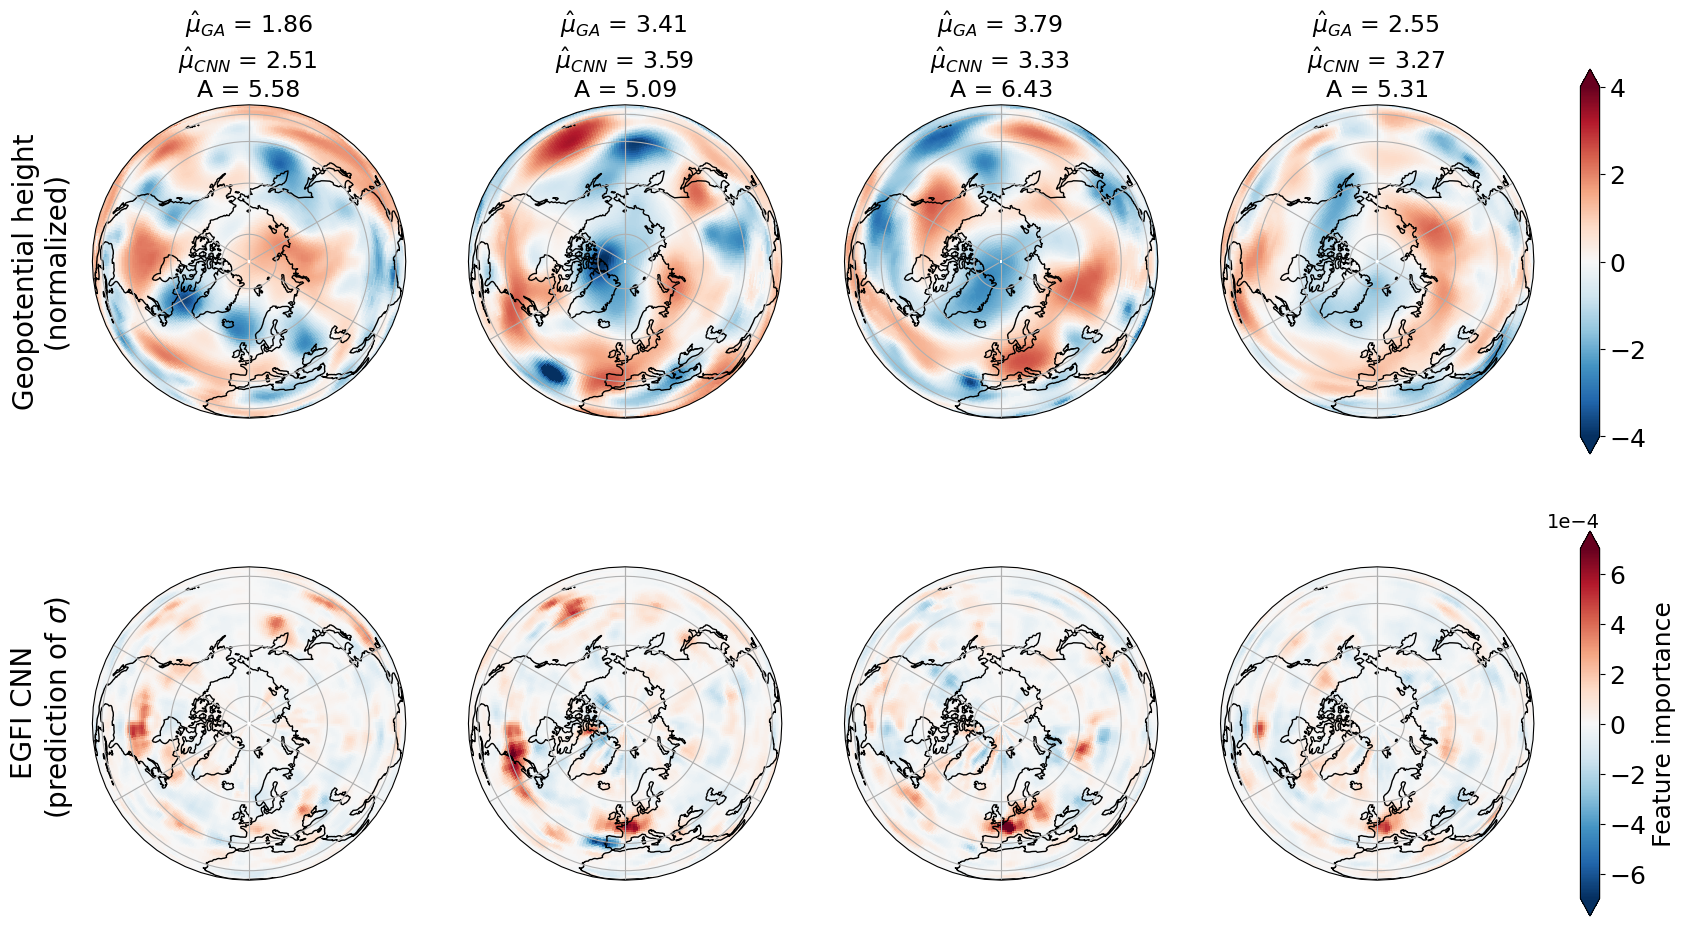

In [6]:
# set matplotlib default params
plt.rcParams.update(plt.rcParamsDefault)
# Do the same as before nut in a one plot with 10 subplots (2 lines of 5 subplots)
# Create a map projection for the Northern Hemisphere
projection = ccrs.Orthographic(central_latitude=90)
# projection = ccrs.NorthPolarStereo()

# Create a Matplotlib figure and axis
n_col= 4
fig, axs = plt.subplots(2, n_col, subplot_kw={'projection': projection}, figsize=(20, 11))
font_tick = 18
font_size_colorbar = 18
pad_colorbar = 0.03
font_size_title = 17
fraction_colorbar = 0.04

for i, index in enumerate(indices[:n_col]):

    ax = axs[0, i%n_col]
    input_data = X_test_sub[i, :, :, 0].copy()
    # Plot the map data using pcolormesh
    img = ax.pcolormesh(lon, lat, input_data, transform=ccrs.PlateCarree(), cmap='RdBu_r')
    # set the value 0 to white
    img.set_clim(vmin=-4, vmax=4)
    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines()
     # Add colorbar
    if i == n_col -1:
        cbar = plt.colorbar(img, ax=axs[0, :], orientation='vertical', fraction=fraction_colorbar, pad=pad_colorbar, extend='both')
        cbar.ax.tick_params(labelsize=font_tick)
    ax.set_title(r"$\hat{\mu}_{GA}$ = " + f"{mu_ga[index]:.2f} \n" +
                    r"$\hat{\mu}_{CNN}$ = " + f"{preds_mu[i]:.2f} \n" + r"A = " + f"{A_test_sub[i]:.2f}", fontsize=font_size_title)
    # cbar.set_label(f'Z500 normalized anomaly (no unit), \n' + r"$\hat{\mu}_{GA}$ = " + f"{mu_ga[index]:.2f}" +
    #                 r", $\hat{\mu}_{CNN}$ = " + f"{preds_mu[i]:.2f}" + r", A = " + f"{A_test_sub[i]:.2f}", fontsize=13)

    ########### SHAP with predicted mu
    shap_data = shap_values_sigma[i, ...,0].copy()
    shap_data = shap_data/preds_sigma[i] # normalize the feature importance map by the total importance
    import scipy.ndimage
    shap_data = scipy.ndimage.gaussian_filter(shap_data, sigma=1.3)

    ax = axs[1, i%n_col]
    # Plot the map data using pcolormesh
    img = ax.pcolormesh(lon, lat, shap_data, transform=ccrs.PlateCarree(), cmap='RdBu_r') #cmap='jet')
    # set the value 0 to white
    scale =0.0007
    v_min = -scale
    v_max = scale
    # img.set_clim(vmin=-scale*np.abs(map_data).max(), vmax=scale*np.abs(map_data).max())
    img.set_clim(vmin=v_min, vmax=v_max)
    img.set_clim(vmin=None, vmax=None)
    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines()
    if i == n_col -1:
        cbar = plt.colorbar(img, ax=axs[1, :], orientation='vertical', fraction=fraction_colorbar, pad=pad_colorbar, extend='both')
        cbar.ax.tick_params(labelsize=font_tick)  # Increase the font size here
        cbar.formatter.set_powerlimits((0, 2))
        cbar.ax.yaxis.get_offset_text().set_fontsize(14)
        # # cbar.update_ticks()
        cbar.set_label('Feature importance', fontsize=font_size_colorbar)
    # print(np.abs(map_data).max())
    
 


# Add vertical titles
titles = ['Geopotential height \n (normalized)', 'EGFI CNN \n' + r"(prediction of $\sigma$)"]
# for i, title in enumerate(titles):
#     fig.text(0.06, 0.85 - i * 0.31, title, va='center', ha='center', rotation='vertical', fontsize=20)
    # Add vertical titles
for i, title in enumerate(titles):
    fig.text(0.1, 0.7 - i * 0.4, title, va='center', ha='center', rotation='vertical', fontsize=20)

# Adjust layout to make room for the vertical text
# plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.05)

# Show the plot
plt.show()

#### Comparaison EGFI before and after smoothing

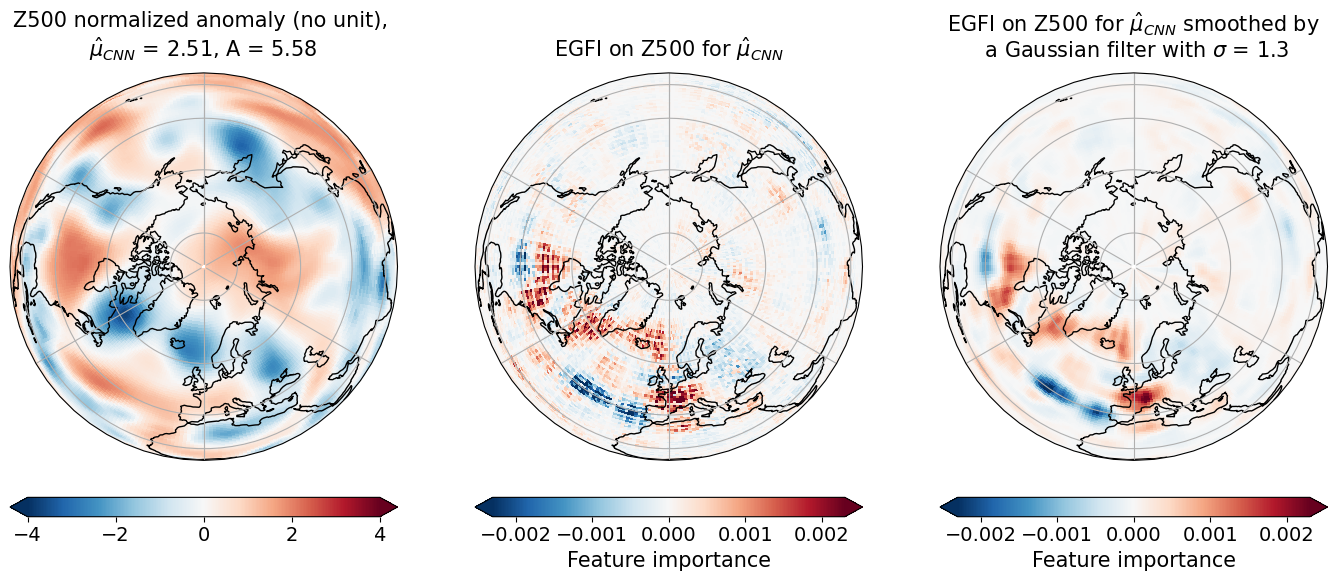

In [7]:
# Select data
index = indices[0]
i=0
input_data = X_test_sub[i, :, :, 0].copy()
map_data = shap_values_mu[0, ...,0].copy()

# import scipy.ndimage
map_data_smooth = scipy.ndimage.gaussian_filter(map_data, sigma=1.3)
map_data /= preds_mu[i]
map_data_smooth /= preds_mu[i]



fig, axs = plt.subplots(1, 3, subplot_kw={'projection': projection}, figsize=(17, 8))
font_tick = 14
font_size_colorbar = 15
pad_colorbar = 0.03
font_size_title = 15
fraction_colorbar = 0.1
pos_title = 1.02
pad_colorbar = 0.06


ax = axs[0]
# Plot the map data using pcolormesh
img = ax.pcolormesh(lon, lat, input_data, transform=ccrs.PlateCarree(), cmap='RdBu_r')
# set the value 0 to white
img.set_clim(vmin=-4, vmax=4)
# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()
# Add colorbar
cbar = plt.colorbar(img, ax=ax, orientation='horizontal', fraction=fraction_colorbar, pad=pad_colorbar, extend='both')
cbar.ax.tick_params(labelsize=font_tick)
ax.set_title(f'Z500 normalized anomaly (no unit), \n'  +
                r"$\hat{\mu}_{CNN}$ = " + f"{preds_mu[i]:.2f}" + r", A = " + f"{A_test_sub[i]:.2f}", fontsize=font_size_title, y=pos_title)




ax = axs[1]
img = ax.pcolormesh(lon, lat, map_data, transform=ccrs.PlateCarree(), cmap='RdBu_r') #cmap='jet')
# set the value 0 to white
# scale = 0.85
# img.set_clim(vmin=-scale*0.06, vmax=scale*0.06)
scale = 0.0023
img.set_clim(vmin=-scale*1., vmax=scale*1.)
# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()
# Add colorbar
cbar = plt.colorbar(img, ax=ax, orientation='horizontal', fraction=fraction_colorbar, pad=pad_colorbar, extend='both')
cbar.ax.tick_params(labelsize=font_tick)
cbar.set_label('Feature importance', fontsize=font_size_colorbar)
ax.set_title('EGFI on Z500 for ' + r'$\hat{\mu}_{CNN}$', fontsize=font_size_title, y=pos_title)

ax = axs[2]
img = ax.pcolormesh(lon, lat, map_data_smooth, transform=ccrs.PlateCarree(), cmap='RdBu_r') #cmap='jet')
# set the value 0 to white
img.set_clim(vmin=-scale*1., vmax=scale*1.)
# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()
# Add colorbar
cbar = plt.colorbar(img, ax=ax, orientation='horizontal', fraction=fraction_colorbar, pad=pad_colorbar, extend='both')
cbar.ax.tick_params(labelsize=font_tick)
cbar.set_label('Feature importance', fontsize=font_size_colorbar)
ax.set_title(r'EGFI on Z500 for $\hat{\mu}_{CNN}$' + ' smoothed by \n' + r' a Gaussian filter with $\sigma$ = 1.3', fontsize=font_size_title, y=pos_title)
plt.show()